In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Conditioning Tasks

In [2]:
class FirstOrderCondRNN(nn.Module):
    def __init__(self, *, n_kc=200, n_mbon=20, n_fbn=60, n_ext=2, n_out=1,
                 T_int=30, T_stim=2, dt=0.5, f_ones=0.1, n_hop=0, n_seed=None):
        super().__init__()

        # Set constants
        W_kc_mbon_max = 0.05
        self.kc_mbon_min = 0.  # Minimum synaptic weight
        self.kc_mbon_max = W_kc_mbon_max  # Maximum synaptic weight
        self.W_kc_mbon_0 = Variable(torch.ones((n_mbon, n_kc)) * W_kc_mbon_max,
                                    requires_grad=False)
        self.tau_w = 5  # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1  # Time scale of output circuitry activity
        self.n_int = 2  # Number of task intervals
        self.T_int = T_int  # Length of task interval [seconds]
        self.T_stim = T_stim  # Length of stimulus presentation [seconds]
        self.dt = dt  # Length of simulation time step [seconds]
        self.n_hop = n_hop

        # Set the sizes of layers
        n_dan = n_mbon
        self.n_kc = n_kc
        self.n_mbon = n_mbon
        self.n_fbn = n_fbn
        self.n_dan = n_dan
        self.n_recur = n_mbon + n_fbn + n_dan
        self.n_ext = n_ext
        self.n_out = n_out
        self.n_ones = int(n_kc * f_ones)

        # Define network variables used to store data
        # Odors
        self.train_odors = None
        self.eval_odors = None
        # Training parameters (for continuation)
        self.train_T_vars = None
        self.train_rts = None
        self.train_Wts = None
        self.train_wts = None
        self.train_vts = None
        self.train_vt_opts = None
        self.train_CS_stim = None
        self.train_US_stim = None
        self.train_loss = None
        # Evaluation parameters (for plotting and analysis)
        self.eval_rts = None
        self.eval_Wts = None
        self.eval_wts = None
        self.eval_vts = None
        self.eval_vt_opts = None
        self.eval_CS_stim = None
        self.eval_US_stim = None
        self.eval_loss = None
        self.eval_err = None

        # Set the seed
        if n_seed is None:
            # self.gen = n_seed
            gen = n_seed
            self.n_seed = 1234
        else:
#             gen = None
            np.random.seed(n_seed)
            torch.manual_seed(n_seed)
            gen = torch.Generator()
            gen = gen.manual_seed(n_seed)
            # self.gen = gen

        # Define updatable network parameters
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_mbon = torch.zeros((self.n_recur, n_mbon))
        mean_fbn = torch.zeros((self.n_recur, n_fbn))
        mean_dan = torch.zeros((self.n_recur, n_dan))
        W_mbon = torch.normal(mean_mbon, torch.sqrt(1 / (sqrt2 * n_mbon)),
                              generator=gen)
        W_fbn = torch.normal(mean_fbn, torch.sqrt(1 / (sqrt2 * n_fbn)),
                             generator=gen)
        W_dan = torch.normal(mean_dan, torch.sqrt(1 / (sqrt2 * n_dan)),
                             generator=gen)
        self.W_recur = nn.Parameter(torch.cat((W_mbon, W_fbn, W_dan), dim=1),
                                    requires_grad=True)
        mean_readout = torch.zeros((n_out, n_mbon))
        std_readout = 1 / torch.sqrt(torch.tensor(n_mbon, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout,
                                                   generator=gen),
                                      requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.n_recur) * 0.1,
                                 requires_grad=True)
        # Project the context (ext) signals to the DANs if FBNs are removed
        if n_hop == 1:
            self.W_ext = nn.Parameter(torch.randn(n_dan, n_ext),
                                      requires_grad=True)
        else:
            self.W_ext = nn.Parameter(torch.randn(n_fbn, n_ext),
                                      requires_grad=True)
        
#     def forward(self, r_kc, r_ext, time, batch_size=30):
#         """ Defines the forward pass of the RNN
        
#         Synaptic weights from the Keyon cells to the mushroom body output neurons (MBONs)
#         are fixed for each trial. All other weights are network parameters.
        
#         The KC->MBON weights are set within the range [0, 0.05].
#         MBONs receive external input from Keyon cells (r_kc i.e. 'odors').
#         Feedback neurons (FBNs) receive external contextual input (r_ext i.e. 'context').
#         DAN->MBON weights are permanently set to zero. DANs receive no external input.

#         Inputs
#             r_kc = activity of the Kenyon cell neurons (representing odors)
#             r_ext = context signals (representing the conditioning context)
#             time = time vector for a single interval
#             W0 = initial weights for KC->MBON connections
#             batch_size = number of trials in batch

#         Returns
#             r_recur: list of torch.ndarray(batch_size, n_mbon + n_fbn + n_dan)
#                 = time series of activities in the output circuitry
#             readout: list of torch.ndarray(batch_size, 1)
#                 = time series of valence readouts (represents behaviour)
#         """

#         # Define the time step of the simulation
#         dt = np.diff(time)[0]

#         # Initialize output circuit firing rates for each trial
#         r_init = torch.ones((batch_size, self.n_recur)) * 0.1
#         r_init[:, :self.n_mbon] = 0
#         r_recur = [r_init]

#         # Initialize KC->MBON weights
#         readout = [torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.n_mbon]).squeeze()]

#         # Set the weights DAN->MBON to zero
#         W_recur = self.W_recur.clone()
#         W_recur[:self.n_mbon, -self.n_dan:] = 0

#         # Update activity for each time step
#         for t in range(time.size()[0] - 1):
#             # Define the input to the output circuitry
#             I_kc_mbon = torch.einsum('bmk, bk -> bm', self.W_kc_mbon.repeat(batch_size, 1, 1), r_kc[:, :, t])
#             I_FBN = torch.einsum('bfe, be -> bf', self.W_ext.repeat(batch_size, 1, 1), r_ext[:, :, t])
#             I = torch.zeros((batch_size, self.n_recur))
#             I[:, :self.n_mbon] = I_kc_mbon
#             I[:, self.n_mbon:self.n_mbon + self.n_fbn] = I_FBN

#             # Update the output circuitry activity
#             Wr_prod = torch.einsum('bsr, br -> bs', W_recur.repeat(batch_size, 1, 1), r_recur[-1])
#             dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(batch_size, 1) + I)) / self.tau_r
#             r_recur.append(r_recur[-1] + dr * dt)

#             # Calculate the readout
#             readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.n_mbon])))

#         return r_recur, readout
            
    def forward(self, r_kc, r_ext, time, n_batch=30, W0=None, r0=None,
                ud_wts=True, ko_wts=None, **kwargs):
        """ Defines the forward pass of the RNN

        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Kenyon cells (r_kc i.e. 'odors').
        Feedback neurons (FBNs) receive external input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero.
        DANs receive no external input.

        Parameters
            r_kc = activity of the Kenyon cell inputs (representing odors)
            r_ext = context inputs (representing the conditioning context)
            time = time vector for a single interval
            n_batch = number of trials in mini-batch
            W0 = initial weights for KC->MBON connections
            r0 = initial activities for output circuitry neurons
            ud_wts = indicate whether to update dynamic weights
                True: KC->MBON plasticity is on
                False: KC->MBON plasticity turned off
            ko_wts = list of MBON indices to be knocked out

        Returns
            r_recur: list of torch.ndarray(batch_size, n_mbon + n_fbn + n_dan)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, n_recur, n_recur)
                = time series of KC->MBON weights (dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        if r0 is not None:
            r_init = r0
        else:
            r_init = torch.ones(n_batch, self.n_recur) * 0.1
            r_init[:, :self.n_mbon] = 0
        r_recur = [r_init]

        # Initialize the eligibility traces and readout
        r_bar_kc = r_kc[:, :, 0]
        r_bar_dan = r_recur[-1][:, -self.n_dan:]
        readout = [torch.einsum('bom, bm -> bo',
                                self.W_readout.repeat(n_batch, 1, 1),
                                r_recur[-1][:, :self.n_mbon]).squeeze()]

        # Clone the readout weight in case it has to be modified
        W_readout = self.W_readout.clone()
        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        if self.n_hop == 0:
            W_recur[:self.n_mbon, -self.n_dan:] = 0
        elif self.n_hop == 1:
            W_recur[:self.n_mbon, -self.n_dan:] = 0
            W_recur[self.n_mbon:(self.n_mbon + self.n_fbn), :] = 0
            W_recur[:, self.n_mbon:(self.n_mbon + self.n_fbn)] = 0
        elif self.n_hop == 2:
            W_recur[:(self.n_mbon + self.n_fbn), -(self.n_dan + self.n_fbn):] = 0
        # Knockout specified weights
        if ko_wts is None:
            ko_wts = []
        for n in ko_wts:
            W_recur[:, n] = 0
            W_readout[:, n] = 0

        # Initialize the KC->MBON weights
        W_kc_mbon = [W0[0]]
        wt = [W0[1]]

        # Update activity for each time step
        for t in range(time.shape[0] - 1):
            # Define the input to the output circuitry
            I_tot = torch.zeros((n_batch, self.n_recur))
            I_kc_mbon = torch.einsum('bmk, bk -> bm',
                                     W_kc_mbon[-1], r_kc[:, :, t])
#             I_kc_mbon = torch.einsum('bmk, bk -> bm',
#                                      self.W_kc_mbon.repeat(n_batch, 1, 1),
#                                      r_kc[:, :, t])
            I_tot[:, :self.n_mbon] = I_kc_mbon
            # Project the context (ext) signals to the DANs if FBNs are removed
            if self.n_hop == 1:
                I_dan = torch.einsum('bde, be -> bd',
                                     self.W_ext.repeat(n_batch, 1, 1),
                                     r_ext[:, :, t])
                I_tot[:, (self.n_mbon + self.n_fbn):] = I_dan
            else:
                I_fbn = torch.einsum('bfe, be -> bf',
                                     self.W_ext.repeat(n_batch, 1, 1),
                                     r_ext[:, :, t])
                I_tot[:, self.n_mbon:(self.n_mbon + self.n_fbn)] = I_fbn

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs',
                                   W_recur.repeat(n_batch, 1, 1),
                                   r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(n_batch, 1)
                                        + I_tot)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            if ud_wts:
                r_dan_dt = r_recur[-1][:, -self.n_dan:]
                wt_out = self.wt_update(W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan,
                                        r_kc[:, :, t], r_dan_dt, n_batch,
                                        **kwargs)
                r_bar_kc, r_bar_dan = wt_out

            # Calculate the readout (see Eq. 2)
            readout.append(torch.einsum('bom, bm -> bo',
                                        W_readout.repeat(n_batch, 1, 1),
                                        r_recur[-1][:, :self.n_mbon]).squeeze())

        return r_recur, (W_kc_mbon, wt), readout
#         return r_recur, readout

    def wt_update(self, W_kc_mbon, wt, dt, r_bar_kc, r_bar_dan, r_kc, r_dan,
                  n_batch, **kwargs):
        """ Returns directly the static KC->MBON plasticity variables

        Since this class has no plasticity, the KC->MBON weights and plasticity
        variables are not updated. Therefore, the values are returned directly.

        Parameters
            W_kc_MBON: list = KC->MBON weight matrices
            wt = dynamic plasticity update
            dt = time step of simulation
            r_bar_kc = eligibility trace of Kenyon cell activity
            r_bar_dan = eligibility trace of dopaminergic cell activity
            r_kc = current activity of Kenyon cells
            r_dan = current activity of dopamine cells
            n_batch = number of trials in mini-batch
        """

        return r_bar_kc, r_bar_dan

    def train_net(self, T_int=40, T_stim=2, dt=0.5, n_epochs=2000, n_batch=30,
                  n_odors=10, reset_wts=True, clip=0.0001, train=True, plot=None):
        """ Trains a network on classical conditioning tasks.

        Tasks include first-order or second-order conditioning, or extinction. Tasks consist of
        a single intervals, and since there is no plasticity, activites are not reset between
        consecutive stimulus presentations (network relies on persistent activity to represent
        associations). Each task has its own input generating function. Stimuli are presented
        between 5-15s and 20-30s respectively.

        Parameters
            network = RNN network to be trained or ran
            task = type of conditioning task to be trained ('first-order', 'all_tasks')
            T_int = length of task intervals (eg conditioning, test, extinction)
            T_stim = length of time each stimulus is presented
            dt = time step of simulations
            n_epochs = number of epochs to train over
            n_batch = number of trials in mini-batch
            p_ctrl = the fraction of trials that are control (to prevent over-fitting)
            clip = maximum gradient allowed during training
            train = boolean indicating whether to perform backprop
            plot = type of task to run (for plotting purposes)

        Returns
            r_out_epoch = output circuit neuron activities for final epoch
            vt_epoch = readout (i.e. valence) for final epoch
            vt_opt = target valence for final epoch
            loss_hist = list of losses for all epochs
            ls_stims = list of stimulus time series
        """

        # Present the stimulus between 5-15s and 20-30s of the interval
        stim_min1 = 5
        stim_max1 = 15 - T_stim
        stim_range1 = int((stim_max1 - stim_min1) / dt)
        stim_offset1 = int(stim_min1 / dt)
        stim_min2 = 20
        stim_max2 = 30 - T_stim
        stim_range2 = int((stim_max2 - stim_min2) / dt)
        stim_offset2 = int(stim_min2 / dt)
        # Length of stimulus in indices
        stim_len = int(T_stim / dt)
        # Interval time vector
        time_int = torch.arange(0, T_int + dt/10, dt)

        # Neuron population sizes
        n_kc = self.n_kc
        n_ext = self.n_ext
        n_mbon = self.n_mbon
        # Max KC->MBON weight values
        W_kc_mbon_max = self.kc_mbon_max

        # Define a set of 10 odors (CS)
        n_ones = int(n_kc * 0.1)
        odor_list = torch.zeros(n_odors, n_kc)
        gen = torch.Generator()
        gen = gen.manual_seed(self.n_seed)
        odor_inds = torch.multinomial(torch.ones(n_odors, n_kc), n_ones, generator=gen)
        neut_inds = torch.multinomial(torch.ones(n_kc), n_ones, generator=gen)
        neut_odor = torch.zeros(n_kc)
        neut_odor[neut_inds] = 1
        for n in range(n_odors):
            # Define an odor (CS)
            odor_list[n, odor_inds[n, :]] = 1

        # List to store losses
        loss_hist = []

        # Initialize the KC-MBON weights
        W_in = None

        for epoch in range(n_epochs):
            # Lists to store activities, weights, readouts and target valences
            r_outs = []
            vts = []

            # Set the intial KC->MBON weight values for each trial
            if reset_wts or (W_in is None):
                W_in = self.init_w_kc_mbon(None, n_batch, (epoch, n_epochs))
            else:
                W_in = (W_in[0][-1].detach(), W_in[1][-1].detach())

            # Randomly determine the time of each stimulus presentation
            stim_times1 = torch.multinomial(torch.ones(stim_range1), n_batch, replacement=True) + stim_offset1
            stim_times2 = torch.multinomial(torch.ones(stim_range2), n_batch, replacement=True) + stim_offset2
            stim_times = torch.stack((stim_times1.view(-1, 1), stim_times2.view(-1, 1)), dim=1)

            # Generate the odor (r_kc) and context (r_ext) inputs, and target valence (vt_opt)
            r_kc, r_ext, vt_opt, ls_stims = first_order_inputs(stim_times, stim_len, time_int.size()[0], odor_list, n_kc, n_ext, n_batch, plot)

            # Run the forward model
#             r_int, vt = self(r_kc, r_ext, time_int, n_batch)
            r_int, _, vt = self(r_kc, r_ext, time_int, n_batch, W_in)
#             net_out = self(r_kc[i], r_ext[i], time_int, n_batch, W_in)
#             rt_int, (Wt_int, wt_int), vt_int = net_out
#             # Pass the KC->MBON weights to the next interval
#             W_in = (Wt_int[-1], wt_int[-1])

            # Append the interval outputs to lists
            r_outs += r_int
            vts += vt

            # Concatenate the activities, weights and valences
            r_out_epoch = torch.stack(r_outs, dim=-1)
            vt_epoch = torch.stack(vts, dim=-1)

            # Calculate the loss
            loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -self.n_dan:, :])

            if train:
                # Update the network parameters
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), clip)
                optimizer.step()

            # Print an update
            if epoch % 500 == 0:
                print(epoch, loss.item())
            loss_hist.append(loss.item())

        return r_out_epoch, vt_epoch, vt_opt, loss_hist, ls_stims

    def init_w_kc_mbon(self, W_in, n_batch, e_tup):
        """ Initializes the KC->MBON weights for the task.

        KC->MBON weights are reset at the beginning of each epoch.

        Parameters
            W_in = specified initial weight values or None
            n_batch = number of trials in mini-batch
            e_tup: tuple = (current epoch, total training epochs)

        Returns
            tuple of initial KC->MBON and dynamic plasticity variables
        """

        if W_in is None:
#             wt0 = self.W_kc_mbon_0.repeat(n_batch, 1, 1)
            wt0 = self.W_kc_mbon.repeat(n_batch, 1, 1)
            W_in = (wt0.clone(), wt0.clone())

        return W_in



In [3]:
class NoPlasticityRNN(FirstOrderCondRNN):
    def __init__(self, *, n_odors=10, odor_seed=12345678, **kwargs):
        super().__init__(**kwargs)
        # Set the static KC->MBON weights
        W_kc_mbon_max = 0.05
        self.W_kc_mbon = Variable(torch.rand(self.n_mbon, self.n_kc) *
                                  W_kc_mbon_max, requires_grad=False)
        # Generate a static list of odors for the network to train on
        self.n_odors = n_odors
        gen = torch.Generator()
        gen = gen.manual_seed(odor_seed)
        odor_list = torch.zeros(n_odors, self.n_kc)
        odor_inds = torch.multinomial(torch.ones(n_odors, self.n_kc),
                                      self.n_ones, generator=gen)
        for n in range(n_odors):
            # Define an odor (CS)
            odor_list[n, odor_inds[n, :]] = 1
        self.train_odors = odor_list
        # Set the number of task intervals
        self.n_int = 1


In [4]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eq. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [5]:
# Define functions for each of the conditioning tasks
# Some detail provided in Jiang 2020 -> Methods -> Networks without dopamine-gated plasticity
def first_order_inputs(stim_times, stim_len, time_len, odor_list, n_kc, n_ext, n_batch, plot=None, p_omit=0.3):
    """ Generates inputs for first-order conditioning tasks.
    
    All trials are either CS+, CS- (US omitted) or CS omitted (control trials to avoid over-fitting).
    Of the trials where CS or US is omitted, a second parameter determines the relative fractions of
    CS or US trials omitted (p_omit_CS). See Figure 2 of Jiang 2020 to determine sequencing of stimuli
    during training. To account for the sequential nature of numerical simulations, the target valence
    is set to begin one time step after stimulus onset.
    
    All trials are CS+ or control trials where CS+ is switched out for a neutral CS in the second
    presentation. In the case where the CS is switched, the target valence is zero. To account for the
    sequential nature of numerical simulations, the target valence is set to begin one time step after
    stimulus onset.
    
    The mix of conditions is listed as follows:
        probability of trials where CS+ is switched = 0.5
    
    Parameters
        stim_times = randomly selected indices of stimulus presentations for each interval
        stim_len = length of stimulus presentation (in indices)
        time_len = size of time vector
        odor_list = list of 10 odors used for all training
        n_kc = number of Kenyon cell input neurons
        n_ext = number of contextual input neurons
        n_batch = number of trials in mini-batch
        plot = used when plot function is called, indicates which task to plot
        p_omit = probability of omitting either CS or US from trials
        
    Returns
        r_kct = odor (KC) input time series array for trial
        r_extt = context (ext) input time series array for trial
        vt_opt = time series of target valence for plotting and loss calculations
        ls_stims = list of stimulus time series for plotting
    """
    
    # Conditioned stimuli (CS) = odors
    odor_inds = torch.multinomial(torch.ones(odor_list.shape[0]), n_batch, replacement=True)
    r_kc = torch.zeros(n_batch, n_kc)
    for b in range(n_batch):
        # Define an odor (CS) for each trial
        r_kc[b, :] = odor_list[odor_inds[b], :]
    # Unconditioned stimuli (US) = context
    r_ext = torch.multinomial(torch.ones(n_batch, n_ext), n_ext)
    
    # Determine whether CS2+ is switched (switch on half of trials)
    switch_inds = torch.rand(n_batch) < 0.5

    # Initialize activity matrices
    r_kct = torch.zeros(n_batch, n_kc, time_len)
    r_extt = torch.zeros(n_batch, n_ext, time_len)
    time_CS_both = torch.zeros(n_batch, time_len)
    time_US_both = torch.zeros_like(time_CS_both)
    vt_opt = torch.zeros_like(time_CS_both)
    
    # For each stimulus presentation
    n_ints = 2
    for i in range(n_ints):
        # Initialize time matrices
        time_CS = torch.zeros(n_batch, time_len)
        time_US = torch.zeros(n_batch, time_len)
        
        for b in range(n_batch):
            stim_inds = stim_times[b, i] + torch.arange(stim_len)
            # Set the CS time
            time_CS[b, stim_inds] = 1
            # Set the US time
            if i == 0:
                time_US[b, stim_inds + stim_len] = 1
            # Set the CS+/CS2 and target valence times
            if i == 1:
                # In half the trials, switch the odor (target valence is zero)
                if (plot is None and switch_inds[b]) or plot == 'CS2':
#                     CS2_inds = torch.multinomial(torch.ones(n_kc), int(n_kc * 0.1))
#                     r_kc[b, CS2_inds] = 1
                    CS2_inds = torch.multinomial(torch.ones(n_kc), n_kc)
                    r_kc[b, :] = r_kc[b, CS2_inds]
                    r_ext[b, :] = 0
                # If the odor is not switched, set the target valence
                else:
                    if r_ext[b, 0] == 1:
                        vt_opt[b, (stim_inds + 1)] = 1
                    elif r_ext[b, 1] == 1:
                        vt_opt[b, (stim_inds + 1)] = -1
                        
        # Calculate the stimulus time series (KC = CS, ext = US)
        r_kct += torch.einsum('bm, mbt -> bmt', r_kc, time_CS.repeat(n_kc, 1, 1))
        r_extt += torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
        time_CS_both += time_CS
        time_US_both += time_US

    # Make a list of stimulus times to plot
    ls_stims = [time_CS_both, time_US_both]

    return r_kct, r_extt, vt_opt, ls_stims
    

In [6]:
# def print_trial(network, task1:str, task2:str, dt=0.5):
def print_trial(network, task, n_odors=10, dt=0.5):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        task = the type of task to be plotted ('CS+' or 'CS2')
        dt = time step of the simulation/plot
    """
    
    # Set the labels for the plots
    if task == 'CS+':
        task_title = 'First-Order Conditioning'
    elif task == 'CS2':
        task_title = 'CS+ Generalization'
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, vt, vt_opt, loss_hist, stim_ls = network.train_net(dt=dt, n_epochs=1, n_batch=1, n_odors=n_odors, train=False, plot=task)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_CS = stim_ls[0].numpy().squeeze()
    plot_US = stim_ls[1].numpy().squeeze()
    plot_time = np.arange(plot_CS.size) * dt

    # Plot the conditioning and test
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    # Second-order conditioning involves an additional stimulus time series
    if task == 'CS+':
        ax1.plot(plot_time, plot_CS, label=task)
    else:
        half_ind = plot_time.size // 2
        plot_CSp = np.zeros(plot_time.size)
        plot_CSp[:half_ind] = plot_CS[:half_ind]
        plot_CS2 = np.zeros(plot_time.size)
        plot_CS2[half_ind:] = plot_CS[half_ind:]
        ax1.plot(plot_time, plot_CSp, label='CS+')
        ax1.plot(plot_time, plot_CS2, label=task)
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title(task_title, fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.n_mbon, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [7]:
# Initialize the network
classic_net = NoPlasticityRNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.n_dan)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100])
torch.Size([60, 2])


In [8]:
train_bool = True
if train_bool:
#     r_out, vt, vt_opt, loss_hist, _ = train_net(classic_net, n_epochs=2000, n_odors=10)
    r_out, vt, vt_opt, loss_hist, _ = classic_net.train_net(n_epochs=2000, n_odors=1)


0 0.1248830035328865
500 0.00876458641141653
1000 0.006462544202804565
1500 0.005592116620391607


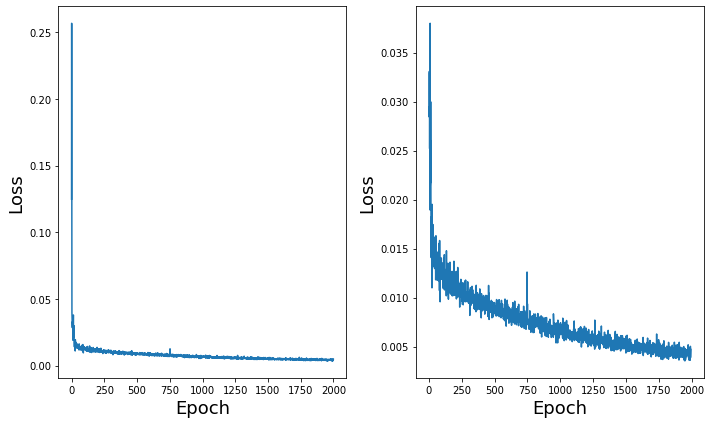

In [9]:
if train_bool:
    # Plot the loss function
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(loss_hist)
    axes[0].set_xlabel('Epoch', fontsize=label_font)
    axes[0].set_ylabel('Loss', fontsize=label_font)
    axes[1].plot(loss_hist[5:])
    axes[1].set_xlabel('Epoch', fontsize=label_font)
    axes[1].set_ylabel('Loss', fontsize=label_font)
    fig.tight_layout();


In [10]:
# torch.save(classic_net.state_dict(), 'trained_N5_no_plasticity_10odors_2000epochs.pt')
# torch.save(classic_net.state_dict(), 'trained_N6_no_plasticity_1odors_2000epochs.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


0 0.004786208271980286
0 0.007415296509861946


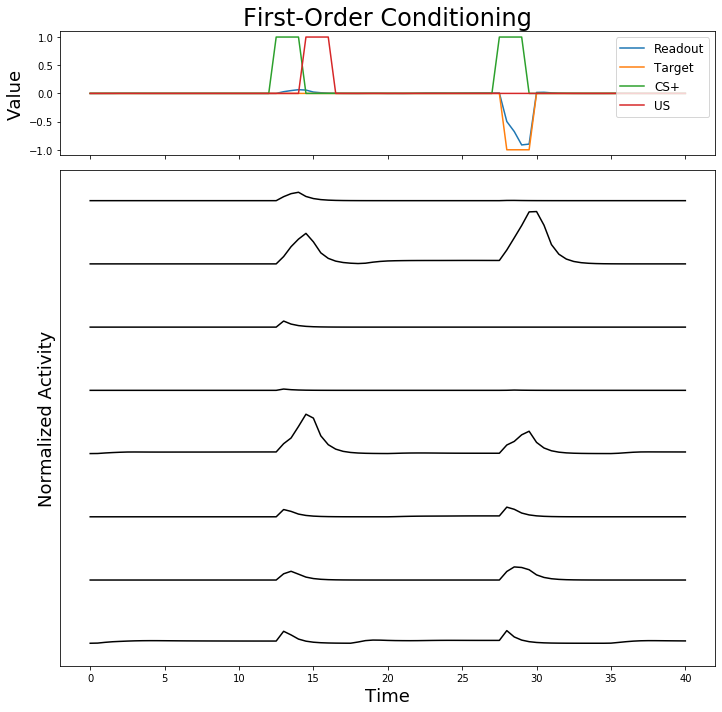

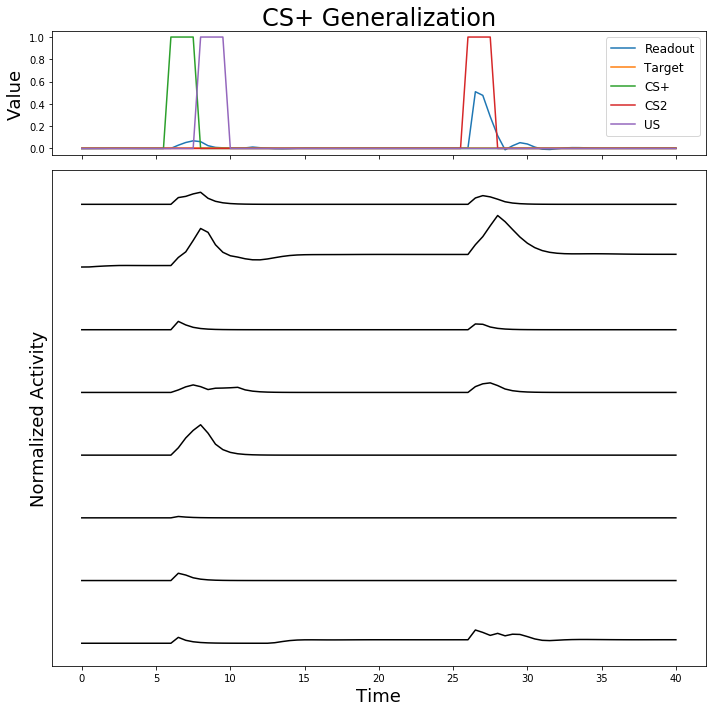

In [11]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
#     classic_net.load_state_dict(torch.load('trained_N5_no_plasticity_10odor_2000epochs.pt'))
#     classic_net.load_state_dict(torch.load('trained_N6_no_plasticity_1odor_2000epochs.pt'))
    classic_net.eval()

print_trial(classic_net, task='CS+', n_odors=1)
print_trial(classic_net, task='CS2', n_odors=1)
